# Mask RCNN Training

USe this notebook to train the model and save the history and model weights for use in local evaluation and prediciton. 

## Load Mask RCNN into Google Colab

In [1]:
!git clone https://github.com/matterport/Mask_RCNN

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 111.84 MiB | 45.41 MiB/s, done.
Resolving deltas: 100% (570/570), done.


## Set up the GPU Environment

In [2]:
#RUN GPU
%tensorflow_version 1.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

"""
#RUN TPU
%tensorflow_version 1.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')
"""

Found GPU at: /device:GPU:0


'\n#RUN TPU\n%tensorflow_version 1.x\nimport tensorflow as tf\nprint("Tensorflow version " + tf.__version__)\ntry:\n  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection\n  print(\'Running on TPU \', tpu.cluster_spec().as_dict()[\'worker\'])\nexcept ValueError:\n  raise BaseException(\'ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!\')\n'

## Move into the Mask RCNN directory and install the package

In [0]:
import os
os.chdir('Mask_RCNN')


In [4]:
!ls


assets	LICENSE      mrcnn	requirements.txt  setup.cfg
images	MANIFEST.in  README.md	samples		  setup.py


In [5]:
!python3 setup.py install;

running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/mrcnn
copying mrcnn/utils.py -> build/lib/mrcnn
copying mrcnn/parallel_model.py -> build/lib/mrcnn
copying mrcnn/visualize.py -> build/lib/mrcnn
copying mrcnn/model.py -> build/lib/mrcnn
copying mrcnn/__init__.py -> build/lib/mrcnn
copying mrcnn/config.py -> build/lib/mrcnn
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/utils.py -> build/bdist.linux-x86_64/egg/mrcnn

## Load Modules

In [6]:
import mrcnn
import mrcnn.model as modellib
from mrcnn.config import Config
from mrcnn import utils
from mrcnn.model import MaskRCNN
from mrcnn import visualize

import numpy as np
import colorsys
import argparse
import random
import os
import sys
import time
import json
import skimage
import datetime
from keras.models import load_model


Using TensorFlow backend.


## Link Google Drive and set up directories

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
homedir='/content/drive/My Drive/Colab Data/'
datadir=homedir+'data/RCNN_test_all/'

In [9]:
#files need to be accessed using os !ls does not work.
os.listdir(homedir)

['model_data', 'data']

## Define the Config and Dataset classes

In [10]:
class myMaskRCNNConfig(Config):
    NAME = "MaskRCNN_config"
 
    # set the number of GPUs to use along with the number of images
    # per GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2
 
    # number of classes (we would normally add +1 for the background)
    NUM_CLASSES = 3+1
   
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 240
    
    # Learning rate (reduced to stop NaN losses)
    #LEARNING_RATE=0.006
    LEARNING_RATE=0.001
    
    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9
    
    # setting Max ground truth instances
    MAX_GT_INSTANCES=10
    
config = myMaskRCNNConfig()
config.display()

"""
DEFINE THE TRAINING AND VALIDATION SETS HERE
"""
check=[]
class MelonDataset(utils.Dataset):

    def load_dataset(self, dataset_dir):
        """Load a subset of the Balloon dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        #             (source (dataset), class (integer), class name)
        self.add_class("melon", 1, "watermelon")
        self.add_class("melon", 2, "canteloupe")
        self.add_class("melon", 3, "honeydew")
      

        # Train or validation dataset?
        #assert subset in ["train", "test"]
        #dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        annotations = json.load(open(os.path.join(homedir, "model_data/all_melon_annot.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]
        for a in annotations:
            if a['filename'] in os.listdir(dataset_dir):
                # Get the x, y coordinates of points of the polygons that make up
                # the outline of each object instance. These are stored in the
                # shape_attributes (see json format above)
        
                if type(a['regions']) is dict:
                        polygons = [r['shape_attributes'] for r in a['regions'].values()]
                        melon_type = [s['region_attributes'] for s in a['regions'].values()]
                        #print('\n\n1:\n\n'+polygons)
                else:
                        polygons = [r['shape_attributes'] for r in a['regions']]
                        melon_type = [s['region_attributes'] for s in a['regions']]
                        #polygons=polygons[0]
                        #print('\n\n2:\n\n'+str(polygons.items()))

    
                #polygons=polygons[0]
        
                # load_mask() needs the image size to convert polygons to masks.
                # Unfortunately, VIA doesn't include it in JSON, so we must read
                # the image. This is only managable since the dataset is tiny.
                image_path = os.path.join(dataset_dir, a['filename'])
                image = skimage.io.imread(image_path)
                height, width = image.shape[:2]
    
                self.add_image(
                    "melon",
                    image_id=a['filename'],  # use file name as a unique image id
                    path=image_path,
                    width=width, height=height,
                    polygons=polygons,
                    melon_type=melon_type)

    def load_mask(self, image_id):
        """
        Generate instance masks for an image.
        
        Returns:
        
        masks: A bool array of shape [height, width, instance count] with
               one mask per instance.
        
        class_ids: a 1D array of class IDs of the instance masks.
        
        """
        # If not a melon dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "melon":
            print('not a melon!')
            return super(self.__class__, self).load_mask(image_id)

        #class_ids = image_info['class_ids']
        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        
        #if info["polygons"]["name"]=="polyline":
        class_id=[]
        #print(len(info["polygons"]))
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1
            m_type=(list(info["melon_type"][i]['type'].keys()))
            class_id.append(self.class_names.index(m_type[0]))
        class_ids = np.array(class_id, dtype=np.int32)
        #class_ids = np.array(class_ids, dtype=np.int32)
        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask, class_ids #np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "melon":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Prepare the Training and Test Sets

In [11]:
# prepare train set
train_set = MelonDataset()
train_set.load_dataset(datadir+'train')
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
# prepare test/val set
test_set = MelonDataset()
test_set.load_dataset(datadir+'test')
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 240
Test: 60


In [12]:
print("Image Count: {}".format(len(train_set.image_ids)))
print("Class Count: {}".format(train_set.num_classes))
for i, info in enumerate(train_set.class_info):
    print("{:3}. {:50}".format(i, info['name']))


Image Count: 240
Class Count: 4
  0. BG                                                
  1. watermelon                                        
  2. canteloupe                                        
  3. honeydew                                          


In [13]:
train_set.class_info

[{'id': 0, 'name': 'BG', 'source': ''},
 {'id': 1, 'name': 'watermelon', 'source': 'melon'},
 {'id': 2, 'name': 'canteloupe', 'source': 'melon'},
 {'id': 3, 'name': 'honeydew', 'source': 'melon'}]

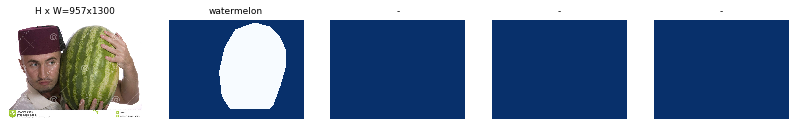

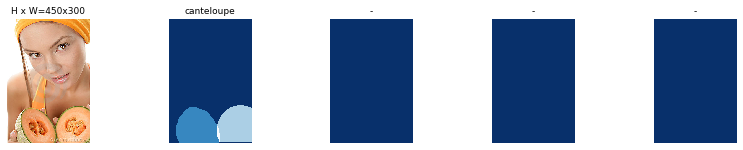

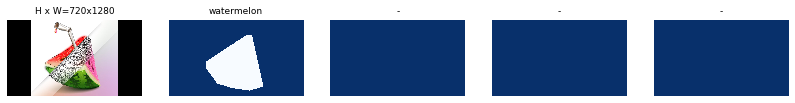

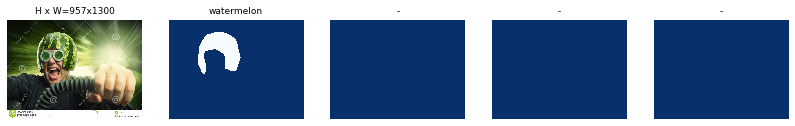

In [15]:
# Load and display random samples
image_ids = np.random.choice(train_set.image_ids, 4)
for image_id in image_ids:
    image = train_set.load_image(image_id)
    mask, class_ids = train_set.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, train_set.class_names)

In [16]:
mask, class_id = train_set.load_mask(150)
class_id

array([3, 3], dtype=int32)

In [17]:
!ls

assets	images	     mask_rcnn.egg-info  requirements.txt  setup.py
build	LICENSE      mrcnn		 samples
dist	MANIFEST.in  README.md		 setup.cfg


# Prepare the Training Model:

In [18]:
print("Loading Mask R-CNN model...")
model = modellib.MaskRCNN(mode="training", config=config, model_dir='./')

#load the weights for COCO
model.load_weights(homedir+'model_data/mask_rcnn_coco.h5', 
                   by_name=True, 
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

Loading Mask R-CNN model...






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead








## Train the Model:

In [19]:
## train heads with higher lr to speedup the learning
model.train(train_set, test_set, learning_rate=2*config.LEARNING_RATE, epochs=15, layers='heads')
history = model.keras_model.history.history


Starting at epoch 0. LR=0.002

Checkpoint Path: ./maskrcnn_config20200227T1210/mask_rcnn_maskrcnn_config_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4   

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'




Epoch 1/15
240/240 [==============================] - 244s 1s/step - loss: 1.2677 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.3357 - mrcnn_class_loss: 0.2068 - mrcnn_bbox_loss: 0.4024 - mrcnn_mask_loss: 0.3155 - val_loss: 0.9502 - val_rpn_class_loss: 0.0050 - val_rpn_bbox_loss: 0.3776 - val_mrcnn_class_loss: 0.1428 - val_mrcnn_bbox_loss: 0.2303 - val_mrcnn_mask_loss: 0.1945

Epoch 2/15
240/240 [==============================] - 148s 618ms/step - loss: 0.8306 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.2971 - mrcnn_class_loss: 0.1505 - mrcnn_bbox_loss: 0.1829 - mrcnn_mask_loss: 0.1938 - val_loss: 0.8939 - val_rpn_class_loss: 0.0062 - val_rpn_bbox_loss: 0.3310 - val_mrcnn_class_loss: 0.1558 - val_mrcnn_bbox_loss: 0.1888 - val_mrcnn_mask_loss: 0.2120
Epoch 3/15
240/240 [==============================] - 165s 687ms/step - loss: 0.6169 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.2003 - mrcnn_class_loss: 0.1251 - mrcnn_bbox_loss: 0.1232 - mrcnn_mask_loss: 0.1636 - val_loss: 0.8535 - val_rp

## Check the Output

In [20]:
#Check the current directory
!ls

assets	images	     maskrcnn_config20200227T1210  README.md	     setup.cfg
build	LICENSE      mask_rcnn.egg-info		   requirements.txt  setup.py
dist	MANIFEST.in  mrcnn			   samples


In [0]:
#Move to the latest model directory
os.chdir('./maskrcnn_config20200227T1210')

## Save Model Weights and History in Google Drive:

In [22]:
#Find the name of the weights to load
#Where the loss goes to nan - can't use these - wont make a prediction!
#See this site for how to solve:
#https://github.com/matterport/Mask_RCNN/issues/296#issuecomment-507282957
!ls -lhrt

total 3.7G
-rw-r--r-- 1 root root 245M Feb 27 12:16 mask_rcnn_maskrcnn_config_0001.h5
-rw-r--r-- 1 root root 245M Feb 27 12:18 mask_rcnn_maskrcnn_config_0002.h5
-rw-r--r-- 1 root root 245M Feb 27 12:21 mask_rcnn_maskrcnn_config_0003.h5
-rw-r--r-- 1 root root 245M Feb 27 12:24 mask_rcnn_maskrcnn_config_0004.h5
-rw-r--r-- 1 root root 245M Feb 27 12:27 mask_rcnn_maskrcnn_config_0005.h5
-rw-r--r-- 1 root root 245M Feb 27 12:31 mask_rcnn_maskrcnn_config_0006.h5
-rw-r--r-- 1 root root 245M Feb 27 12:34 mask_rcnn_maskrcnn_config_0007.h5
-rw-r--r-- 1 root root 245M Feb 27 12:37 mask_rcnn_maskrcnn_config_0008.h5
-rw-r--r-- 1 root root 245M Feb 27 12:40 mask_rcnn_maskrcnn_config_0009.h5
-rw-r--r-- 1 root root 245M Feb 27 12:43 mask_rcnn_maskrcnn_config_0010.h5
-rw-r--r-- 1 root root 245M Feb 27 12:46 mask_rcnn_maskrcnn_config_0011.h5
-rw-r--r-- 1 root root 245M Feb 27 12:49 mask_rcnn_maskrcnn_config_0012.h5
-rw-r--r-- 1 root root 245M Feb 27 12:53 mask_rcnn_maskrcnn_config_0013.h5
-rw-r--r-- 1 r

In [0]:
#now=datetime.datetime.now()
#now_str=now.strftime("%Y%m%dT%H%M")

#Use the same time as the model run for consistency
now_str='20200227T1210'

try:
  os.makedirs(homedir+'saved')
except:
  print('Save directory exists!')

weights_fname =homedir+'saved/weights_all_melon_'+now_str+'.h5'
history_fname =homedir+'saved/history_all_melon_'+now_str+'.json'

model.keras_model.save_weights(weights_fname)

with open(history_fname,"w") as f:
   f.write(json.dumps(history))